This is a course project of EECS495 Deep Learning Foundations From Scratch. This course project builds a time series model using recursive neural network (RNN) built from scratch to predict stock price of Alphabet Inc. The data set used in this project is the historical stock price data of Alphabet Inc from Nov 17, 2016 to Dec 6, 2017 provided by Google Finance. 

In [155]:
import autograd.numpy as np
from autograd.util import flatten_func
from autograd import grad as compute_grad

# import custom utilities and plotter
import hidden_sequence_plotter as plotter

from matplotlib import rcParams
import matplotlib.pyplot as plt
rcParams['figure.autolayout'] = True
%matplotlib notebook

# Dataset

In [156]:
# load the dataset.
stock_data = np.loadtxt('stock.csv', delimiter=',', skiprows=1, usecols=4)[::-1][:, np.newaxis]
print('The dataset contains {} historical (close) stock price.'.format(stock_data.shape[0]))

The dataset contains 268 historical (close) stock price.


The dataset contains is visualized in the cell below.

<IPython.core.display.Javascript object>


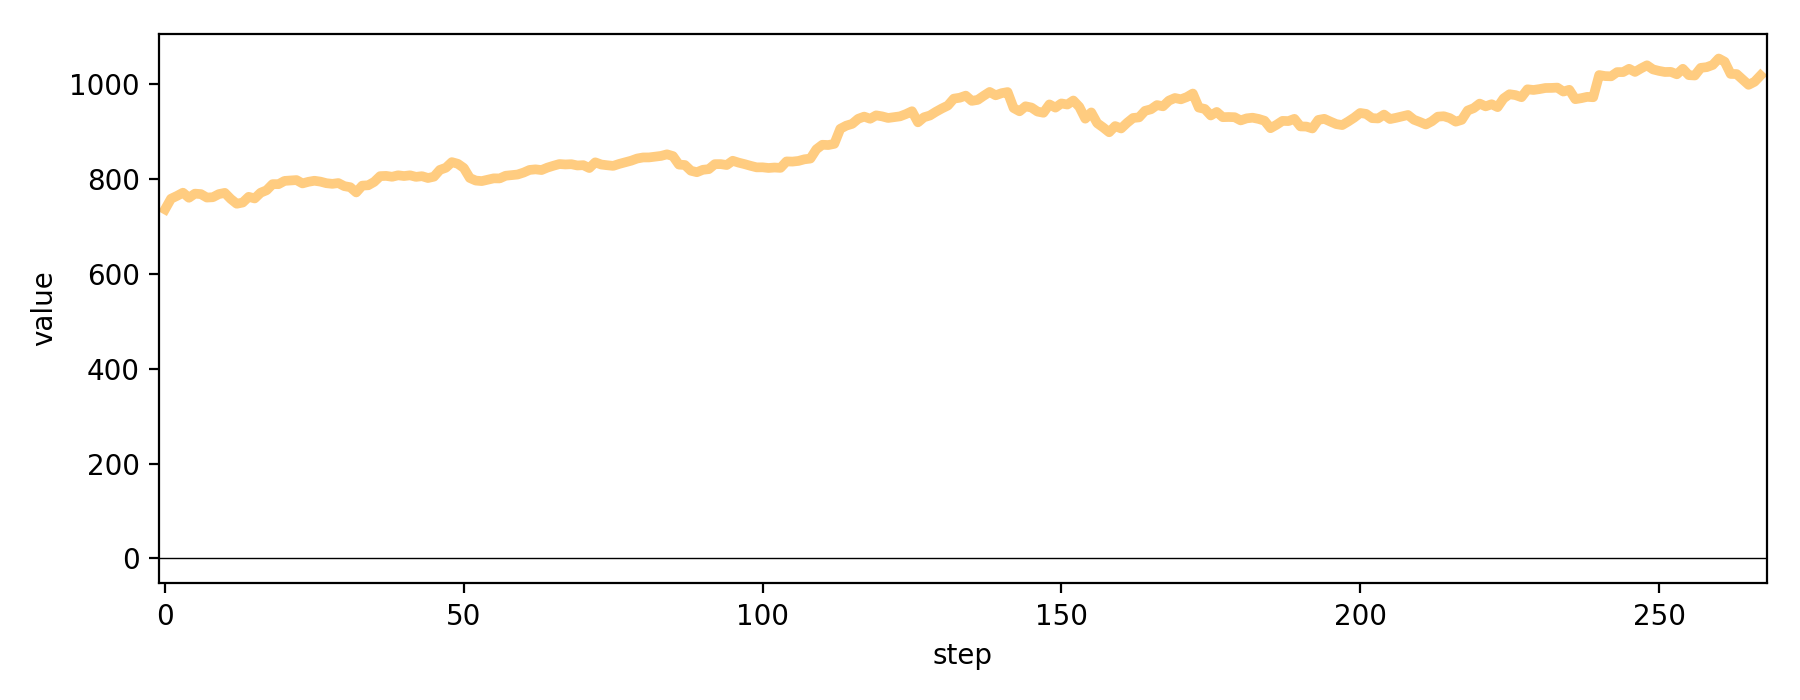

In [157]:
plot_demo = plotter.Visualizer()          
plot_demo.show_sequences(seq1 = stock_data,seq2 = [])

# Data Preparation

To train the machine we need to divide the dataset into test and training sets. In this project, we use the first 238 points as training set, and test our models on the remaining data points. But before splitting the data, we first apply normalization to avoid overflow during optimization. From the plot we can see more clearly the trend of the data.

In [158]:
def normalize(X):
    normed_X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
    return normed_X

# normaliza the data
normed_stock_data = normalize(stock_data)

<IPython.core.display.Javascript object>


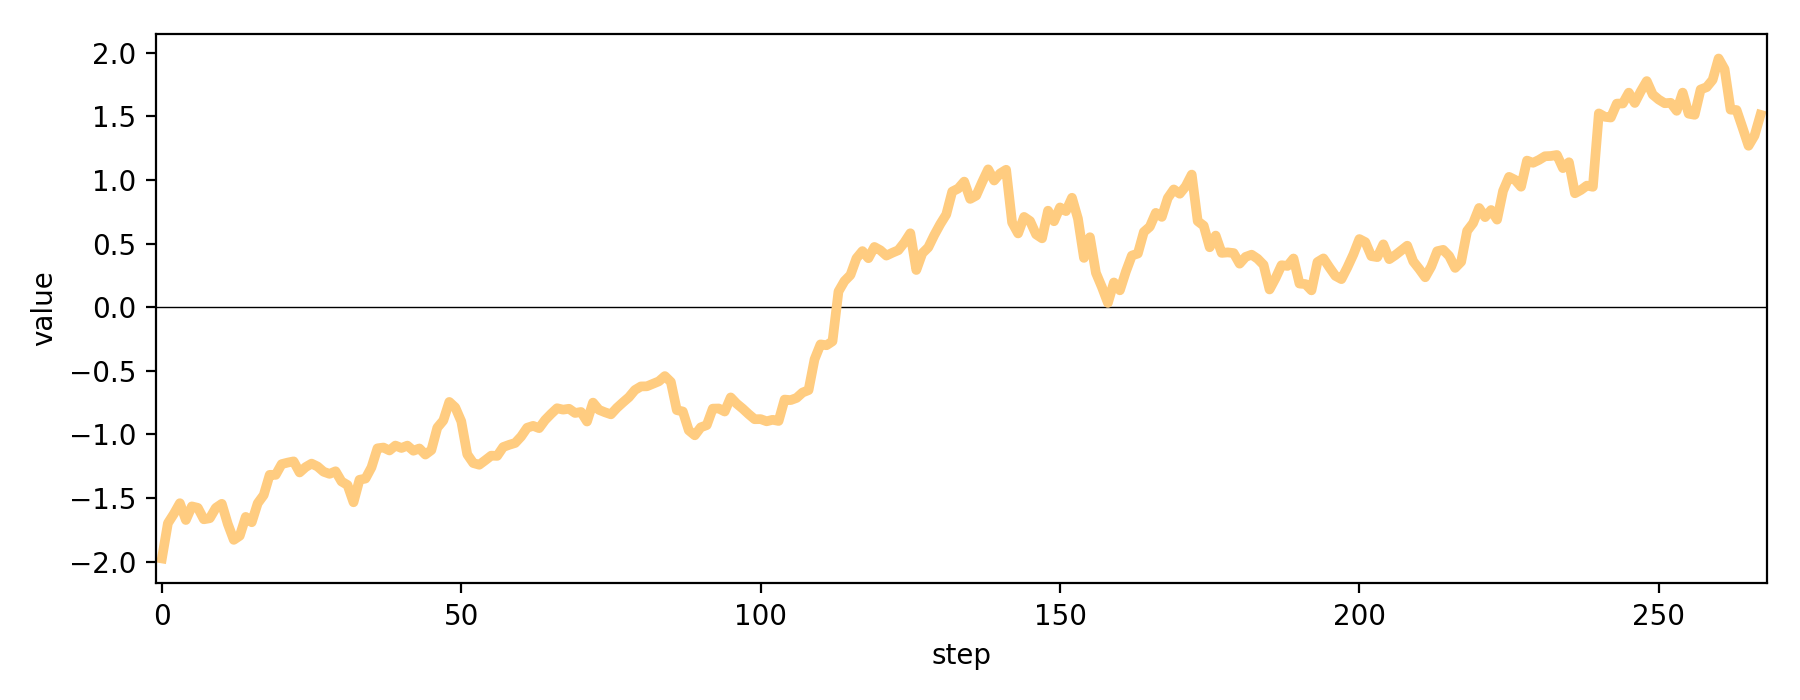

In [169]:
plot_demo.show_sequences(seq1 = normed_stock_data,seq2 = [])

In [159]:
# splits the data into training set and testing set
training_data = normed_stock_data[:238, :]

# Methodology

The following cell defines a linear, parametrized recursion g. s denotes the driver sequence (the stock data) and h denotes the driven sequence:


\begin{equation}
\
h_1 = s_1,\,\,\,h_2 = s_2,...,h_K = s_K \\
h_t = \left(w_0 + w_{h1}h_{t-1} + w_{h2}h_{t-2} + ... + w_{hk}h_{t-K} + w_{s1}s_{t-1} + w_{s2}s_{t-2} + ... + w_{sk}s_{t-K}\right) 
\end{equation}

In [160]:
def g(h,s, w):
    h_t = w[0] + np.dot(h.T,w[1]) + np.dot(s.T,w[2])
    return h_t

The following two cells define a prediction function that takes in a driver sequence and a list of parameters.

In [161]:
def predict(s, w, K):
    h = drive_hidden_sequence(s, g, w, K)
    return h

In [162]:
def drive_hidden_sequence(s, g, w, K):
    '''
    Parameters:
        - s: driver sequence, numpy array, shape(n_samples, 1)
        - g: recursion function
        - w: parameteres, list, [float, shape(k, 1), shape(K, 1)]
        - K: order of recursivity
    Returns:
        - h: driven sequence derived from <s>, numpy array, shape(n_samples, 1)
    '''

    # set first k seed values of hidden sequence to first k values of actual sequence
    h = []
    for k in range(K):
        h.append(s[k])
    
    h_t = np.asarray(h)
    for t in range(len(s) - K):
        # prepare s_t to update hidden sequence element (h_t is already prepared)
        s_t = s[t:t+K]
        h_t_plus_K = g(h_t, s_t, w)
        h_t = h_t[1:]
        h_t = np.vstack([h_t,h_t_plus_K])
        h.append(h_t_plus_K)

    return np.asarray(h)

Here is a batch gradient descent optimizer which we will use to optimize the least squares cost function.

In [163]:
# gradient descent function
def gradient_descent(g,w,alpha,max_its,beta,version):    
    # flatten the input function, create gradient based on flat function
    g_flat, unflatten, w = flatten_func(g, w)
    grad = compute_grad(g_flat)

    # record history
    w_hist = []
   
    # start gradient descent loop
    z = np.zeros((np.shape(w)))      # momentum term
    
    # over the line
    for k in range(max_its):
        # plug in value into func and derivative
        grad_eval = grad(w)
        grad_eval.shape = np.shape(w)

        ### normalized or unnormalized descent step? ###
        if version == 'normalized':
            grad_norm = np.linalg.norm(grad_eval)
            if grad_norm == 0:
                grad_norm += 10**-6*np.sign(2*np.random.rand(1) - 1)
            grad_eval /= grad_norm
            
        # take descent step with momentum
        z = beta*z + grad_eval
        w = w - alpha*z

        # record weight update
        w_hist.append(unflatten(w))

    return w_hist

The next python cell defines a plotter that plots the cost at each iteration. This will help us to examine whether the cost function converges.

In [164]:
## cost function plotter
def show_costs(iters, costs, K):
    fig = plt.figure()
    plt.plot(iters, costs)
    plt.title('cost at each iteration, order {}'.format(K))
    plt.xlabel('iteration')
    plt.ylabel('cost')
    plt.show()

In [165]:
## initializes the parameters
def initializer(k):
    w = [0.1 * np.random.randn(1,1), 0.1 * np.random.randn(k, 1), 0.1 * np.random.randn(k, 1)]
    return w

# Experiments

We will test the cases where k = 1, k = 5 and k = 10,to see which candidate minimizes the cost, and test each model on the testing set.

Now we fit the training data to a RNN model with order = 1.

In [166]:
### K = 1 hidden sequence approximator
# initializes parameters
K = 1
w_init = initializer(K)

# a least squares cost function for order = 1
least_squares = lambda w: np.sum((predict(training_data, w, K) - training_data)**2)

# optimize least squares cost function
alpha = 10**(-2)
max_its = 500
weight_history = gradient_descent(least_squares, w_init, alpha=alpha, max_its=max_its, beta=0.8, version='normalized')
cost_history = [least_squares(w) for w in weight_history]

Now we visualize the changes of costs after 50 iterations. We can see from the plot that the cost function basically converges after 120 iterations.

last 20 cost:
[2.6246391677285423, 2.6385622853723922, 2.6323037719946871, 2.6289002509969599, 2.6246392982837148, 2.6385620427270902, 2.6323035716989001, 2.628900421936474, 2.6246394288332486, 2.6385618000964239, 2.6323033714154178, 2.6289005928681934, 2.624639559377147, 2.6385615574803909, 2.6323031711442404, 2.6289007637921156, 2.6246396899154107, 2.6385613148789839, 2.6323029708853691, 2.628900934708239]


<IPython.core.display.Javascript object>


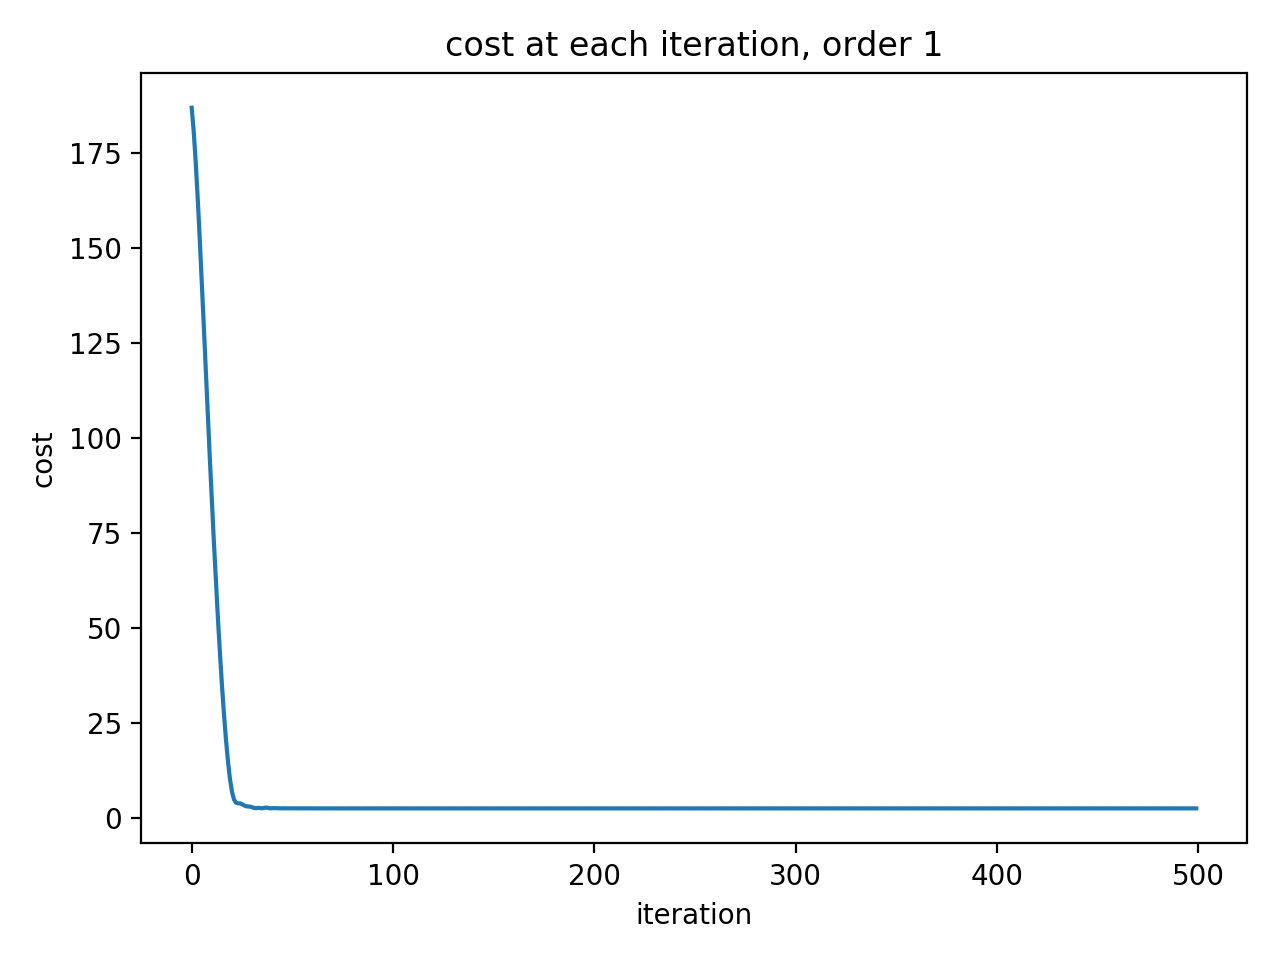

In [167]:
# visualizes the cost to examine convergence
print('last 20 cost:')
print(cost_history[-20:])
show_costs(range(max_its)[:], cost_history[:], K)

In the following python cell, we visualize the driver and hidden sequence generated by the RNN with the best parameters.

the lowest least squares cost when k = 1 is 2.624626316038712


<IPython.core.display.Javascript object>


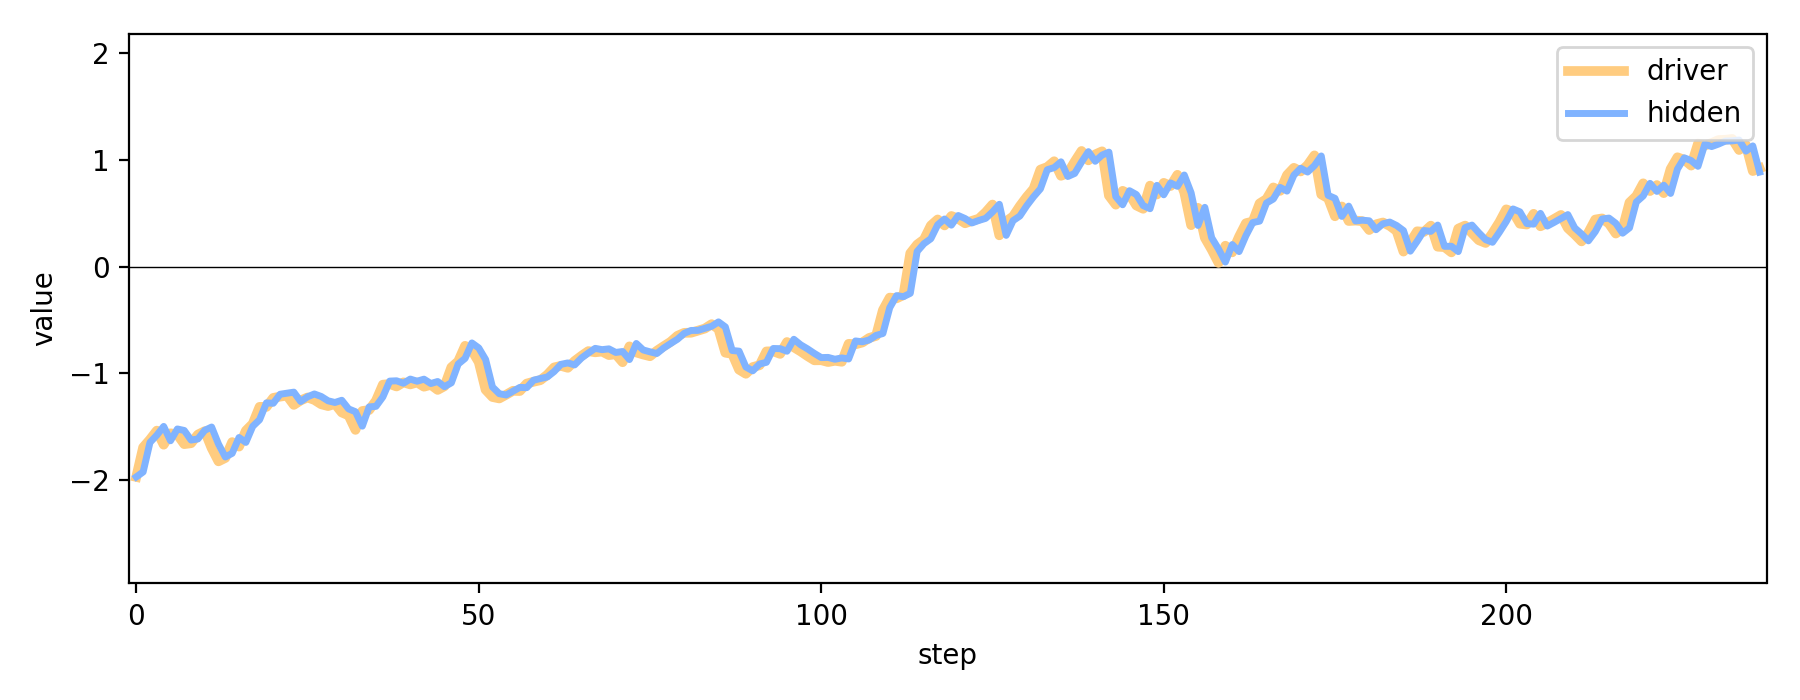

In [168]:
ind_best = np.argmin(cost_history)
best_w_1 = weight_history[ind_best]

# visualize the training data and driven sequence
print ('the lowest least squares cost when k = 1 is {}'.format(cost_history[ind_best]))
hidden_sequence = predict(training_data, best_w_1, K)
plot_demo = plotter.Visualizer()          
plot_demo.show_sequences(seq1 = training_data,seq2 = hidden_sequence, labels = ['driver','hidden'])

In [109]:
### K = 5 hidden sequence approximator
# initializes parameters
K = 5
w_init = initializer(K)
least_squares = lambda w: np.sum((predict(training_data, w, K) - training_data)**2)
alpha = 10**(-2)
max_its = 5000
weight_history = gradient_descent(least_squares, w_init, alpha=alpha, max_its=max_its, beta=0.7, version='normalized')
cost_history = [least_squares(w) for w in weight_history]

last 20 cost:
[2.4198136369633341, 2.4199388342570374, 2.419813634899989, 2.4199388321895334, 2.4198136328529145, 2.4199388301383351, 2.4198136308219862, 2.4199388281033141, 2.419813628807074, 2.4199388260843406, 2.4198136268080512, 2.4199388240812918, 2.4198136248247928, 2.4199388220940383, 2.4198136228571769, 2.4199388201224581, 2.419813620905078, 2.4199388181664245, 2.419813618968373, 2.4199388162258195]


<IPython.core.display.Javascript object>


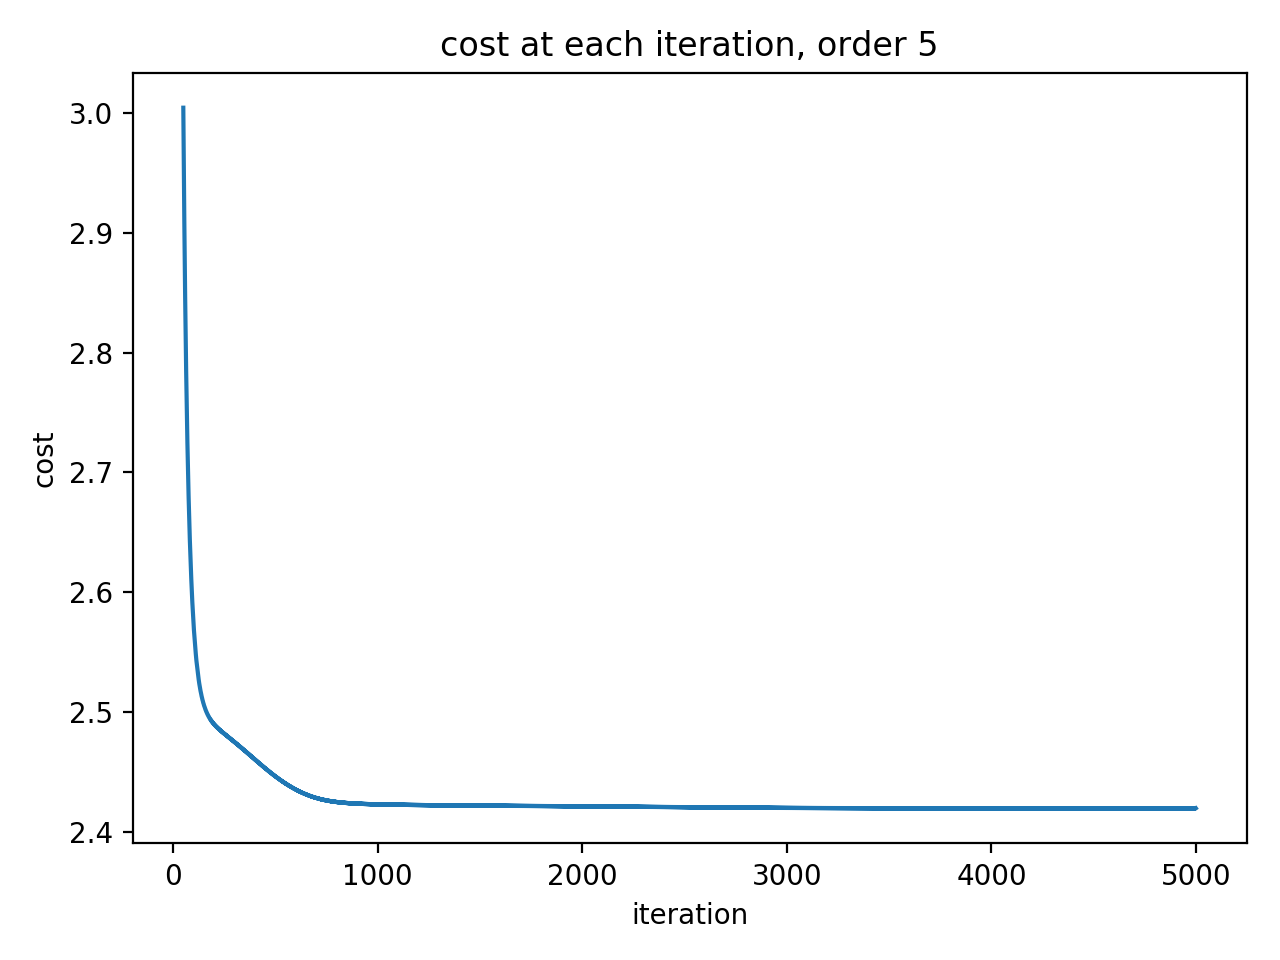

In [111]:
# visualizes the cost to examine convergence
print('last 20 cost:')
print(cost_history[-20:])
show_costs(range(max_its)[50:], cost_history[50:], 5)

the lowest least squares cost when K = 5 is 2.419813618968373


<IPython.core.display.Javascript object>


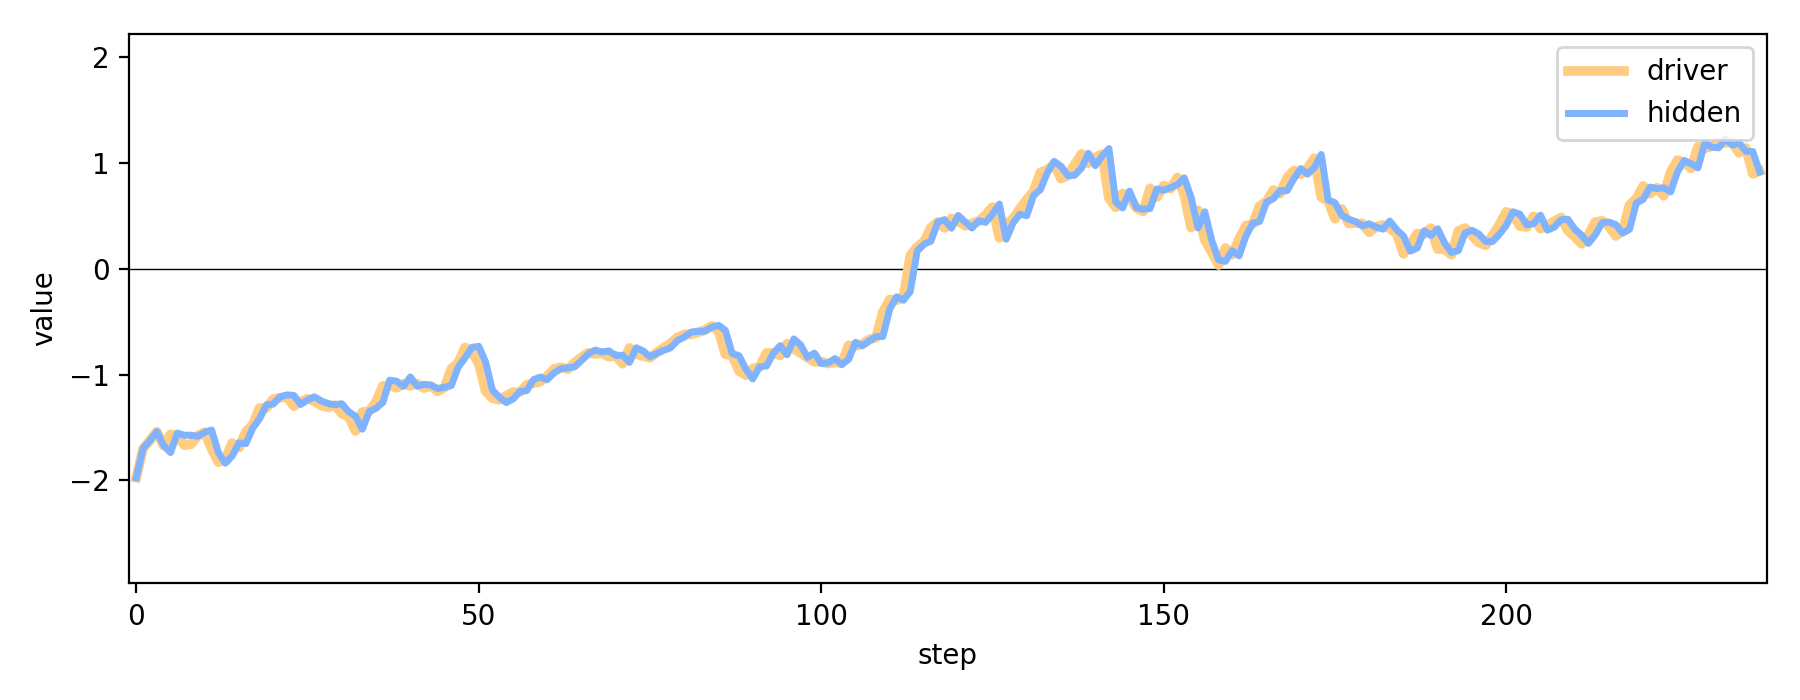

In [112]:
## Visualize the actual sequence and hidden sequence
ind_best = np.argmin(cost_history)
best_w_5 = weight_history[ind_best]

# visualize the training data and driven sequence
print ('the lowest least squares cost when K = 5 is {}'.format(cost_history[ind_best]))
hidden_sequence = predict(training_data, best_w_5, K)
plot_demo.show_sequences(seq1 = training_data,seq2 = hidden_sequence, labels = ['driver','hidden'])

Now we repeat the experiment on an order 10 hidden sequence approximator. The code is the same as above, only the K value is changed.

In [115]:
### K = 10 hidden sequence approximator
# initializes parameters
K = 10
w_init = initializer(K)
least_squares = lambda w: np.sum((predict(training_data, w, K) - training_data)**2)
alpha = 10**(-3)
max_its = 10000
weight_history = gradient_descent(least_squares, w_init, alpha=alpha, max_its=max_its, beta=0.7, version='normalized')
cost_history = [least_squares(w) for w in weight_history]

last 20 cost:
[2.1306655664600385, 2.1306716882323546, 2.1306607643445665, 2.1306668899441945, 2.1306559610227409, 2.1306620904526139, 2.1306511564930153, 2.1306572897560652, 2.1306463507538416, 2.1306524878530073, 2.1306415438036721, 2.1306476847418967, 2.1306367356409623, 2.1306428804211919, 2.1306319262641651, 2.1306380748893492, 2.130627115671734, 2.1306332681448272, 2.1306223038621246, 2.130628460186085]


<IPython.core.display.Javascript object>


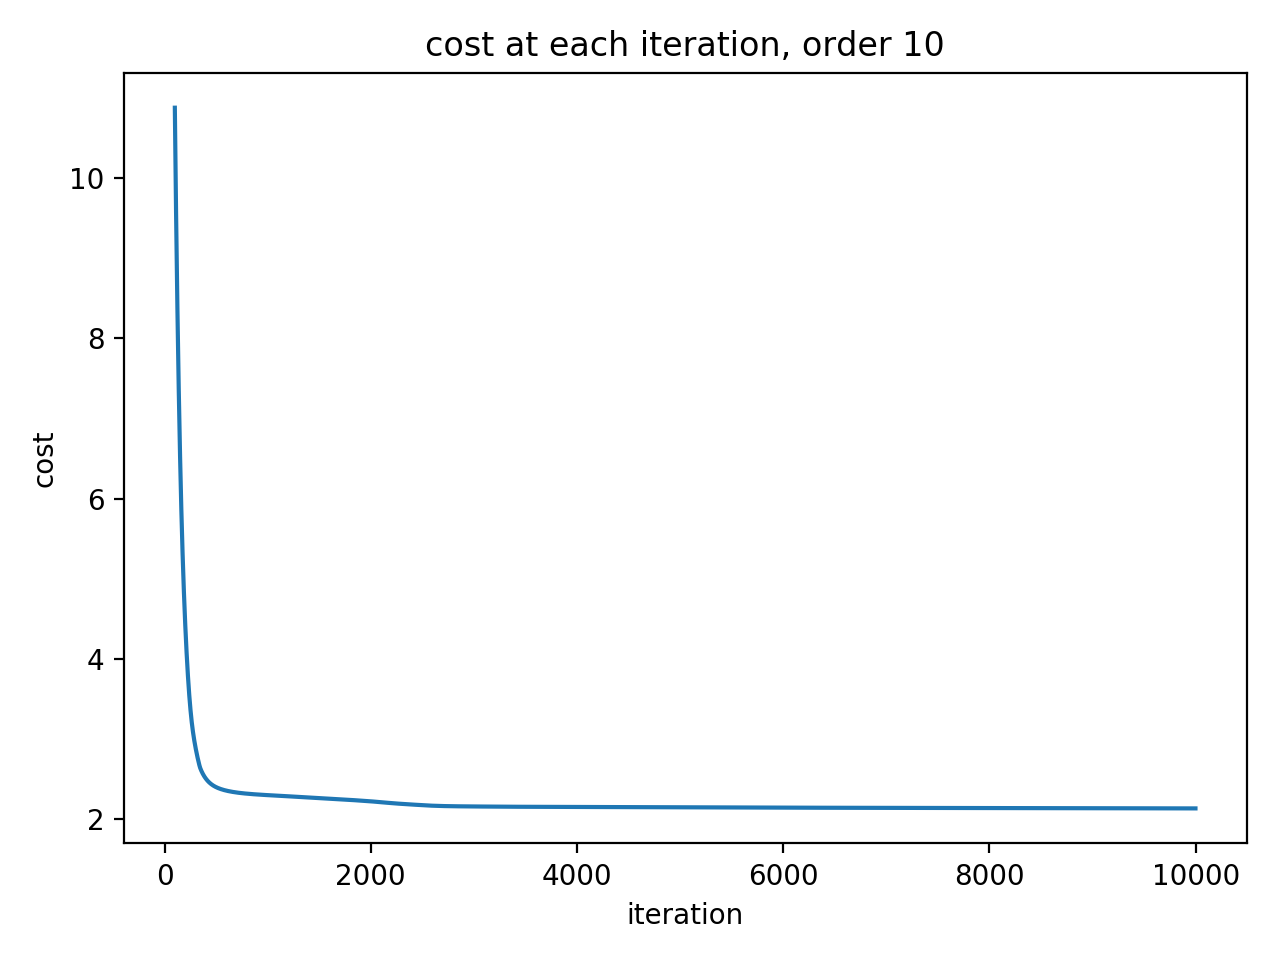

In [121]:
# visualizes the cost to examine convergence
print('last 20 cost:')
print(cost_history[-20:])
show_costs(range(max_its)[100:], cost_history[100:], 10)

the lowest least squares cost when K = 10 is 2.1306223038621246


<IPython.core.display.Javascript object>


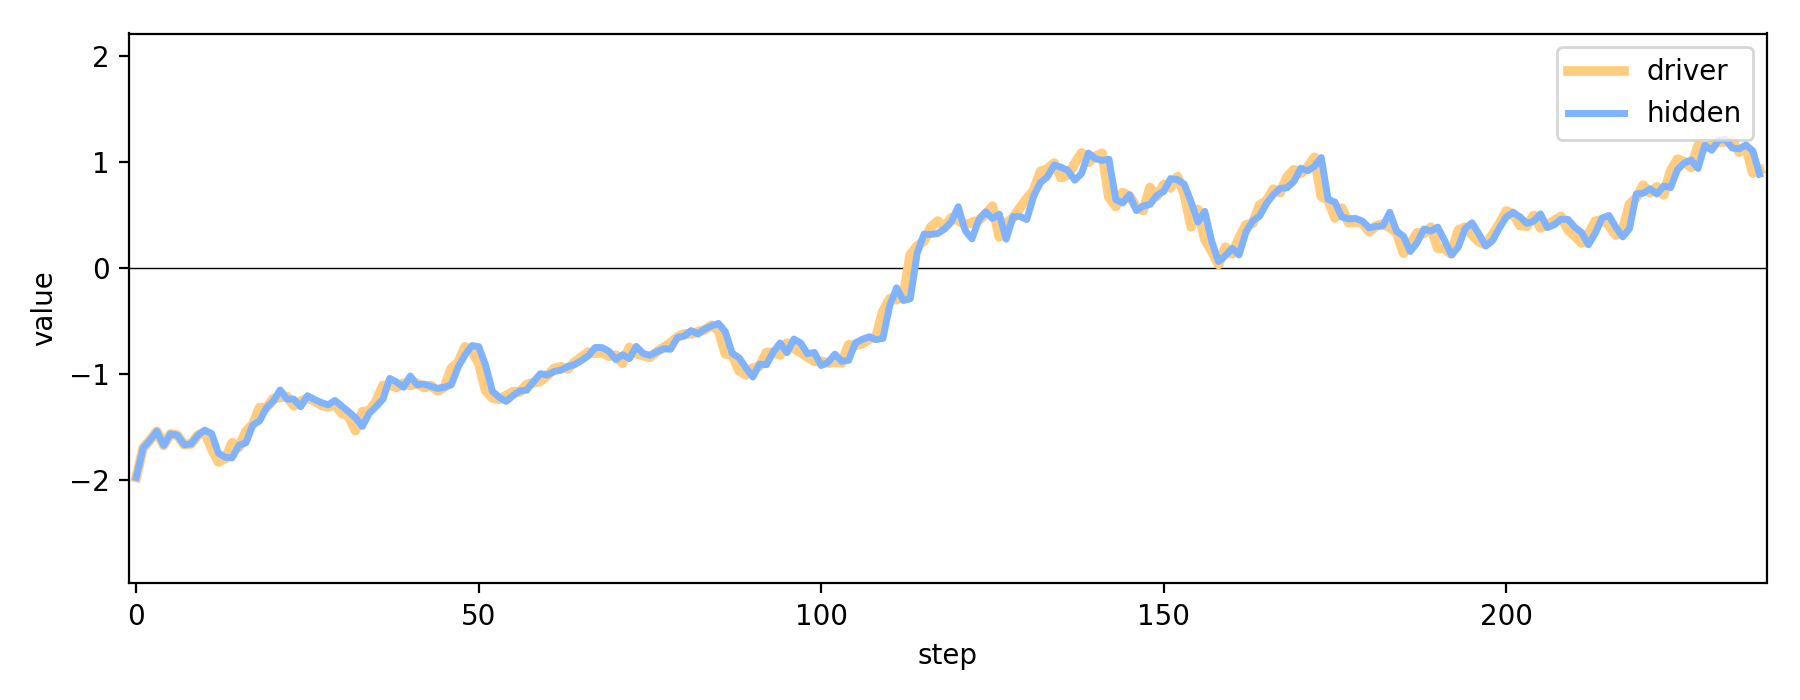

In [122]:
## Visualize the actual sequence and hidden sequence
ind_best = np.argmin(cost_history)
best_w_10 = weight_history[ind_best]

# visualize the training data and driven sequence
print ('the lowest least squares cost when K = 10 is {}'.format(cost_history[ind_best]))
hidden_sequence = predict(training_data, best_w_10, K)      
plot_demo.show_sequences(seq1 = training_data,seq2 = hidden_sequence, labels = ['driver','hidden'])

With the best parameters for order 1, 5 and 10 hidden sequence approximators at hand, we next test them on the testing set to see which overfits the data the least. We will examine the least squares cost on the testing data, and visualize the testing data and the hidden sequences driven by it.

In [131]:
# least squares cost function for testing set
least_squares = lambda hidden_sequence, testing_data: np.sum((hidden_sequence - testing_data)**2)

least squares cost when K = 1 is 0.7052215029942659


<IPython.core.display.Javascript object>


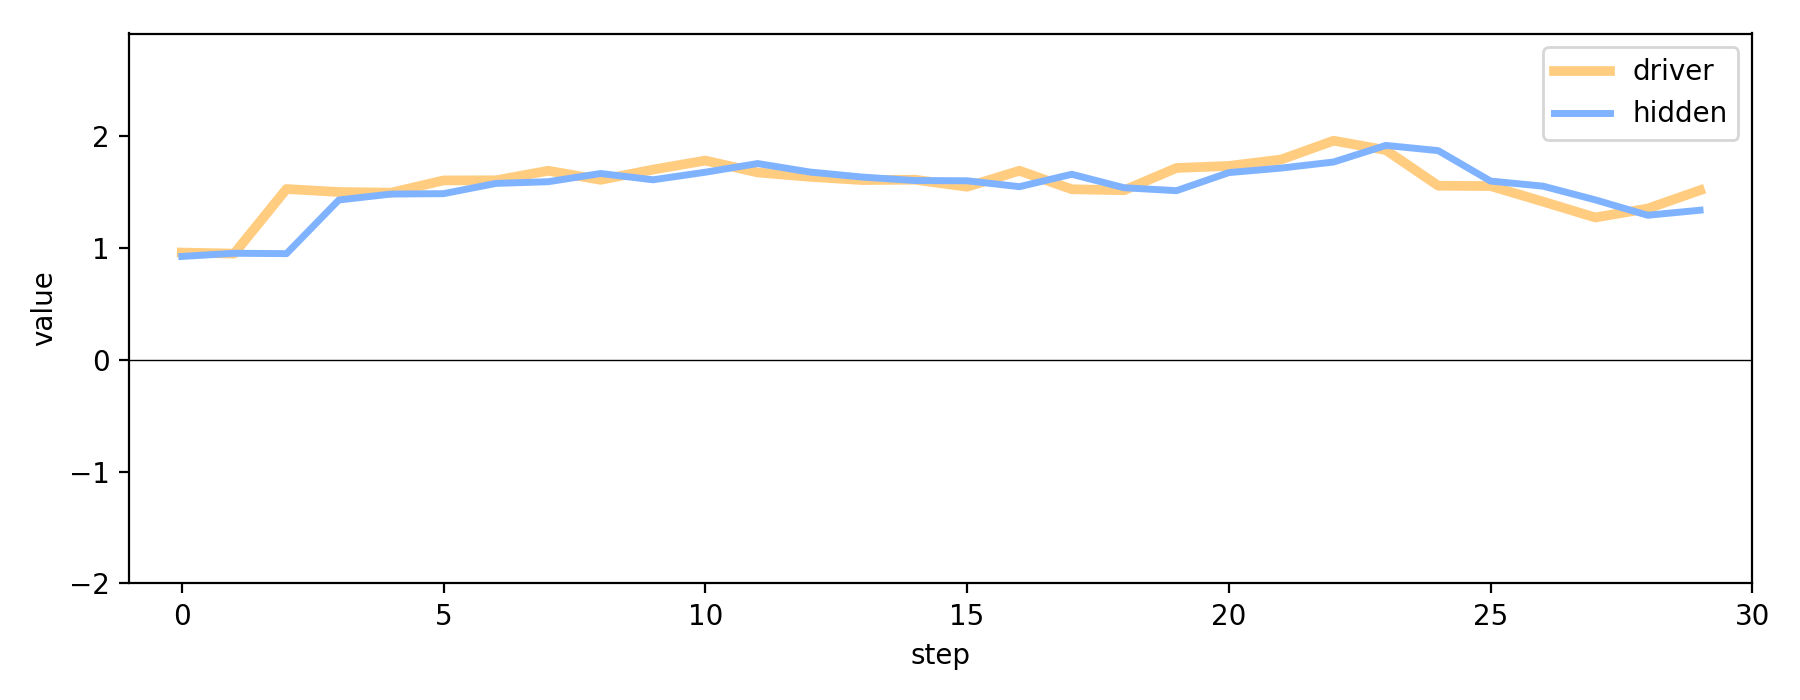

In [133]:
## examine the order 1 hidden sequence approximator
testing_data = normed_stock_data[237:, :]
hidden_sequence = predict(testing_data, best_w_1, 1)
print('least squares cost when K = 1 is {}'.format(least_squares(hidden_sequence[1:], testing_data[1:])))
plot_demo.show_sequences(seq1=testing_data[1:], seq2=hidden_sequence[1:], labels=['driver', 'hidden'])

least squares cost when K = 5 is 0.5854373477589916


<IPython.core.display.Javascript object>


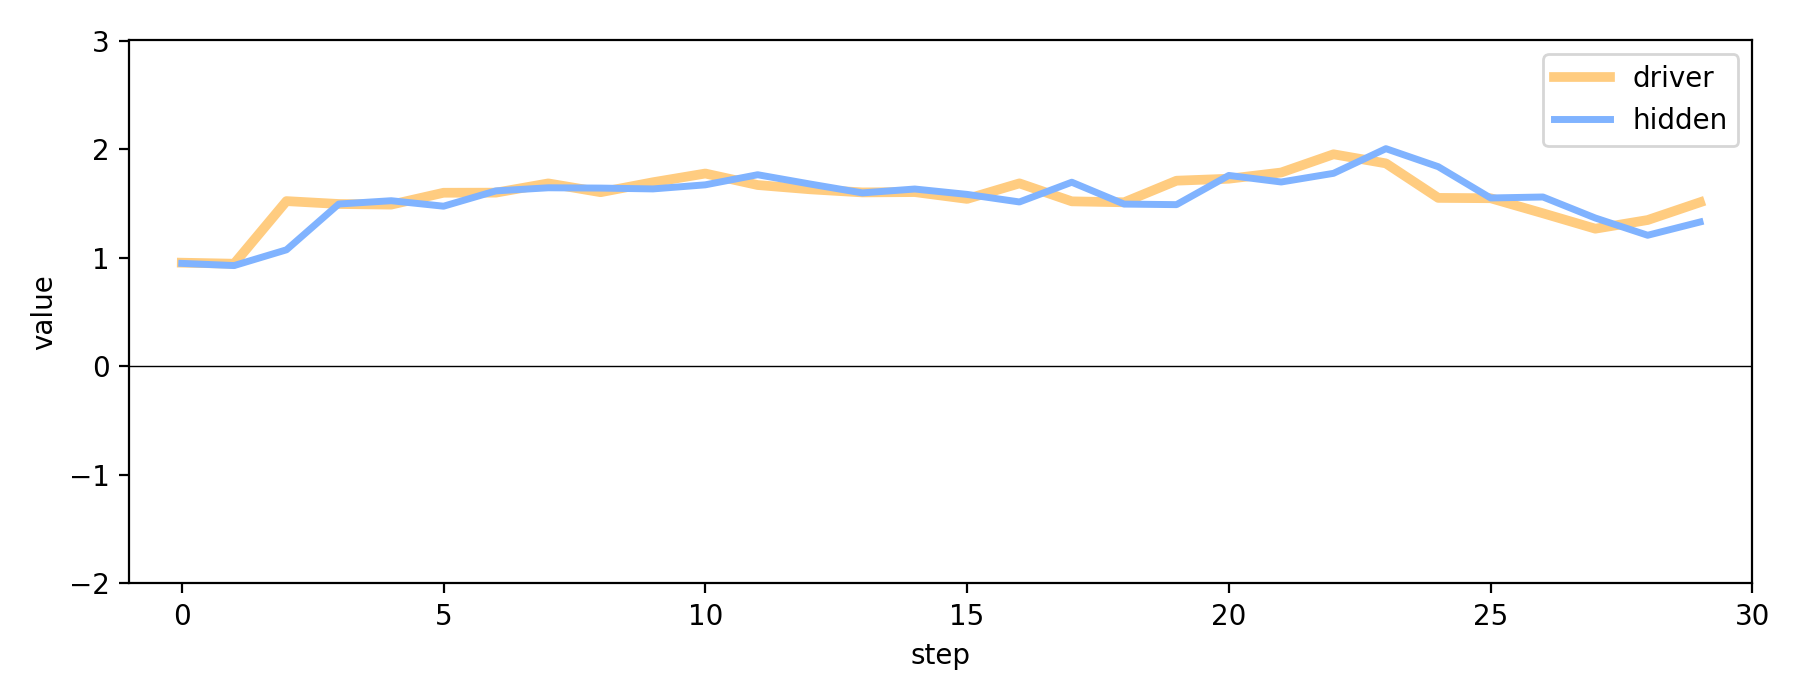

In [135]:
## examine the order 5 hidden sequence approximator
testing_data = normed_stock_data[233:, :]
hidden_sequence = predict(testing_data, best_w_5, 5)
print('least squares cost when K = 5 is {}'.format(least_squares(hidden_sequence[5:], testing_data[5:])))
plot_demo.show_sequences(seq1=testing_data[5:], seq2=hidden_sequence[5:], labels=['driver', 'hidden'])

least squares cost when K = 10 is 0.9800347870628942


<IPython.core.display.Javascript object>


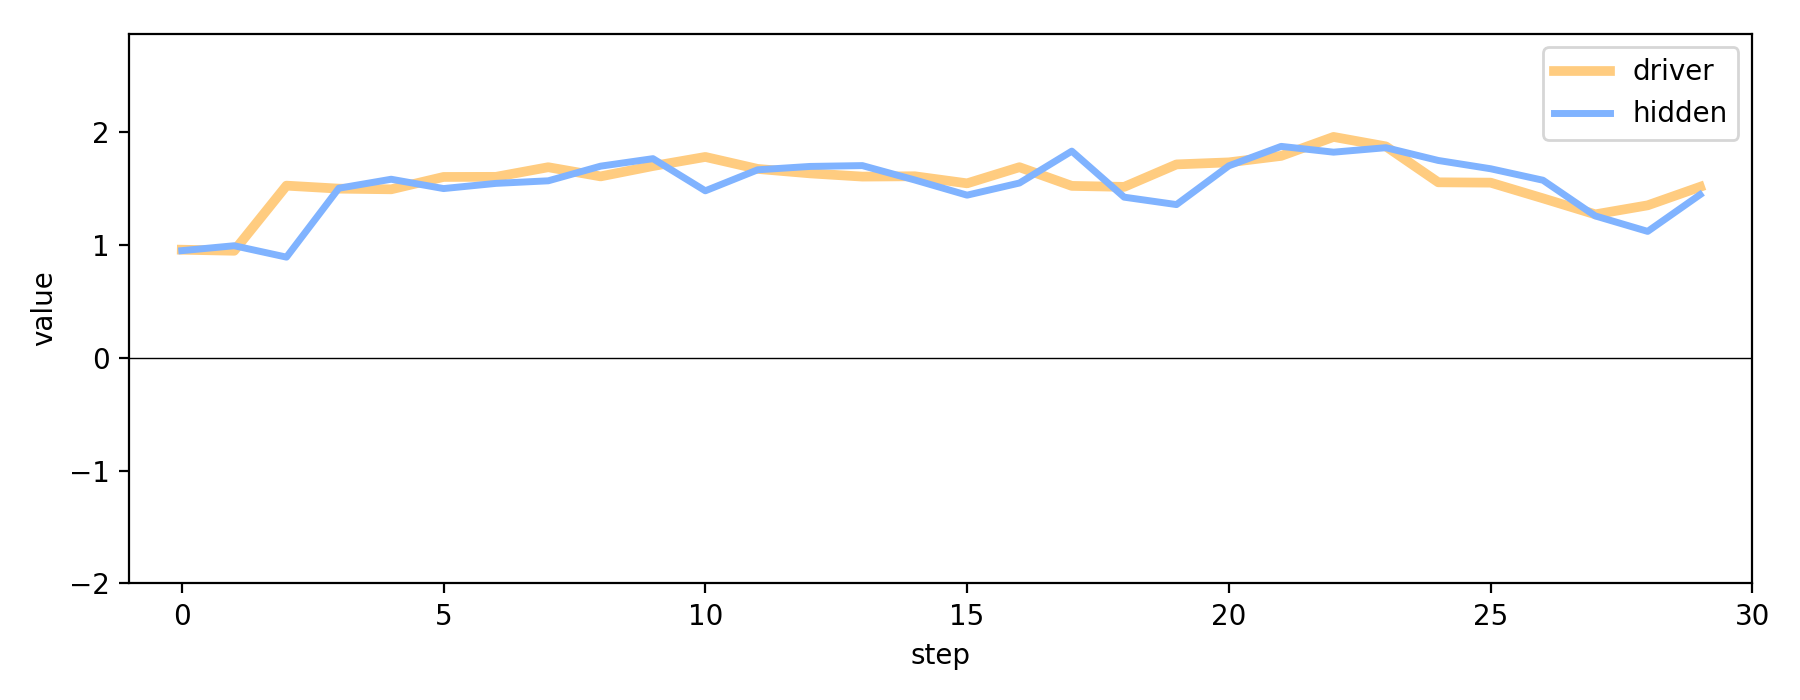

In [136]:
## examine the order 10 hidden sequence approximator
testing_data = normed_stock_data[228:, :]
hidden_sequence = predict(testing_data, best_w_10, 10)
print('least squares cost when K = 10 is {}'.format(least_squares(hidden_sequence[10:], testing_data[10:])))
plot_demo.show_sequences(seq1=testing_data[10:], seq2=hidden_sequence[10:], labels=['driver', 'hidden'])

# Conclusion

The experiments on the testing data show that among the three approximators, the one with order = 5 has the lowest cost. However, because we did not conduct statistical tests, such as t-test, we can not say whether the difference in cost is significant or not.